# BNP Paribas Stock Price HMM Analysis

In this notebook, we will perform a Hidden Markov Model (HMM) analysis on BNP Paribas stock price data. The process is as follows:

1. **Data Reading & Preprocessing**:
   - We load BNP Paribas stock price data from a CSV file, ensuring the date is in correct datetime format.
   - We clean the dataset by removing invalid rows (where close price is missing or zero/negative).
   - We compute log prices and daily log returns.

2. **HMM Training**:
   - We use the [`hmmlearn`](https://hmmlearn.readthedocs.io/en/latest/) library to fit a Gaussian HMM with `n_components=10` hidden states.
     - Internally, `hmmlearn` uses the **Baum-Welch** algorithm for training when we call `.fit()`.

3. **Decoding Hidden States**:
   - After training, we decode the most likely sequence of hidden states for each day using the **Viterbi** algorithm when we call `.predict()`.

4. **Persisting HMM in Neo4j**:
   - We connect to a local Neo4j instance and clear any existing data.
   - We create nodes and relationships to represent the HMM parameters (hidden states, transitions, etc.).

5. **Forecasting**:
   - We define a function to forecast multiple steps ahead by using the model's transition probabilities and state means.

6. **Simulation & Comparison**:
   - We generate synthetic prices from the HMM and compare them to the actual first 100 days of data.
   - We also show an in-sample prediction approach as an additional demonstration.

Let's begin.

## 1. Data Reading and Preprocessing

In this step, we:
1. Read the CSV file containing BNP Paribas stock prices.
2. Convert the `Date` column to a datetime object and sort by date.
3. Clean the data by removing missing or invalid entries.
4. Compute the logarithm of prices (`LogClose`) and then the daily log returns (`LogRet`).

In [10]:
import pandas as pd
import numpy as np

# Read BNP Paribas data from CSV
data_bnp = pd.read_csv('../data/BNPPA.csv')

# Convert 'Date' column to datetime
data_bnp['Date'] = pd.to_datetime(data_bnp['Date'])

# Sort values by date
data_bnp.sort_values('Date', inplace=True)

# Reset index after sorting
data_bnp.reset_index(drop=True, inplace=True)

# Remove rows with missing or invalid Close prices
data_bnp = data_bnp[data_bnp['Close'].notna()]  # remove rows missing close
data_bnp = data_bnp[data_bnp['Close'] > 0]      # remove zero or negative

# Compute log prices & daily log returns
data_bnp['LogClose'] = np.log(data_bnp['Close'])
data_bnp['LogRet']   = data_bnp['LogClose'].diff()

# Replace infinities and drop NaN rows caused by diff()
data_bnp.replace([np.inf, -np.inf], np.nan, inplace=True)
data_bnp.dropna(subset=['LogRet'], inplace=True)

# Display the final cleaned dataframe
data_bnp

,Date,Open,High,Low,Close,Adj Close,Volume,LogClose,LogRet
1,1993-10-19,21.129074,21.228039,20.832178,20.881660,3.838838,8760516.0,3.038871,-0.025732
2,1993-10-20,20.881660,21.129074,20.782696,21.030109,3.866129,6174815.0,3.045955,0.007084
3,1993-10-21,20.980625,21.376488,20.980625,21.376488,3.929806,8263391.0,3.062292,0.016336
4,1993-10-22,21.425970,21.970278,21.376488,21.871313,4.020774,10181091.0,3.085176,0.022884
5,1993-10-25,21.821831,22.019760,21.673384,21.920795,4.029871,4038109.0,3.087436,0.002260
...,...,...,...,...,...,...,...,...,...
7517,2022-12-06,52.250000,52.529999,51.849998,52.459999,52.459999,1969471.0,3.960051,0.002672
7518,2022-12-07,52.349998,52.639999,51.730000,52.000000,52.000000,2131657.0,3.951244,-0.008807
7519,2022-12-08,52.259998,52.349998,51.860001,52.000000,52.000000,1764207.0,3.951244,0.000000
7520,2022-12-09,52.299999,52.889999,51.860001,52.889999,52.889999,2243527.0,3.968214,0.016971


### Reshape Observations
The `hmmlearn` library expects a 2D array of observations. Since we have 1D log returns, we reshape them into a 2D array.

In [11]:
observations = data_bnp['LogRet'].values.reshape(-1, 1)

if np.isnan(observations).any() or np.isinf(observations).any():
    raise ValueError("Observations still contain NaN or Inf - check data pipeline.")

observations

array([[-0.02573248],
       [ 0.00708391],
       [ 0.01633645],
       ...,
       [ 0.        ],
       [ 0.01697055],
       [-0.00397839]])

## 2. Connect to Neo4j
Next, we connect to our local Neo4j database. Before storing anything new, we clear out any existing data for a clean slate.

In [12]:
from py2neo import Graph

# Replace these credentials with your own
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

# Clear the graph
graph.run("MATCH (n) DETACH DELETE n")

(No data)

## 3. HMM Creation and Training
Here, we instantiate the Gaussian HMM with 10 hidden states and train it on our daily log returns. 

**Note**: `hmmlearn` uses the **Baum-Welch** algorithm internally when we call the `fit()` method.

In [13]:
from hmmlearn import hmm

# Define number of hidden states
n_components = 10

# Create the GaussianHMM model
model = hmm.GaussianHMM(
    n_components=n_components,
    covariance_type='full',  # use a full covariance matrix
    n_iter=100,             # maximum number of EM iterations
    random_state=42         # for reproducibility
)

# Train (fit) the model on our log returns.
# As mentioned, hmmlearn uses the Baum-Welch algorithm here.
model.fit(observations)

print("Model has been trained.")

Model has been trained.


## 4. Decoding Hidden States
Once the HMM is trained, we use the `.predict()` method to apply the **Viterbi** algorithm and find the most likely sequence of hidden states for each day. We also extract parameters like the start probabilities, transition matrix, means, and covariances for each state.

In [14]:
# Decode hidden states using Viterbi
# hmmlearn uses the Viterbi algorithm under the hood in .predict()
hidden_states = model.predict(observations)

# Extract important parameters
start_probs = model.startprob_        # shape = (n_components,)
trans_probs = model.transmat_         # shape = (n_components, n_components)
means = model.means_.flatten()        # shape = (n_components,)
covars = model.covars_                # shape depends on covariance_type

# Display the transition matrix (rounded)
transition_matrix_3dec = np.round(trans_probs, 3)
print("Transition Matrix (3 decimals):")
print(transition_matrix_3dec)

Transition Matrix (3 decimals):
[[0.447 0.    0.    0.    0.    0.    0.    0.439 0.    0.114]
 [0.37  0.    0.    0.    0.    0.    0.455 0.175 0.    0.   ]
 [0.    0.009 0.    0.    0.    0.    0.    0.022 0.969 0.   ]
 [0.226 0.    0.    0.708 0.067 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.172 0.77  0.    0.004 0.    0.054]
 [0.    0.    0.    0.    0.973 0.    0.    0.    0.    0.027]
 [0.    0.    0.164 0.    0.    0.    0.    0.    0.836 0.   ]
 [0.    0.    0.008 0.014 0.    0.    0.001 0.978 0.    0.   ]
 [0.    0.    0.843 0.    0.    0.    0.127 0.    0.029 0.   ]
 [0.    0.    0.    0.045 0.    0.    0.    0.    0.    0.955]]


## 5. Persisting the HMM in Neo4j
We store:

1. A parent node to represent the entire HMM.
2. Nodes for each hidden state to store its mean, variance, and start probability.
3. Relationships for each transition probability from state *i* to state *j*.

In [15]:
# Clear any existing data again (optional, if you want a clean start)
graph.run("MATCH (n) DETACH DELETE n")

hmm_name = "BNP_HMM"

# A) Create/update a parent HMM node
create_hmm_query = """
MERGE (h:HMM {name: $hmm_name})
ON CREATE SET h.description = $description
RETURN h
"""

graph.run(
    create_hmm_query,
    hmm_name=hmm_name,
    description=f"GaussianHMM with {n_components} hidden states"
)

# B) Create a node for each state
for i in range(n_components):
    if covars[i].ndim > 1:
        var_value = covars[i].diagonal().mean()
    else:
        var_value = covars[i]

    create_state_query = """
    MERGE (s:State {hmm_name: $hmm_name, state_index: $state_index})
    ON CREATE SET
      s.mean = $mean,
      s.variance = $variance,
      s.start_prob = $start_prob
    RETURN s
    """

    graph.run(
        create_state_query,
        hmm_name=hmm_name,
        state_index=i,
        mean=float(means[i]),
        variance=float(var_value),
        start_prob=float(start_probs[i])
    )

# C) Create relationships for transition probabilities
for i in range(n_components):
    for j in range(n_components):
        prob_ij = float(trans_probs[i, j])

        create_rel_query = """
        MATCH (s1:State {hmm_name: $hmm_name, state_index: $i}),
              (s2:State {hmm_name: $hmm_name, state_index: $j})
        MERGE (s1)-[r:TRANSITION_TO {prob: $prob_ij}]->(s2)
        RETURN r
        """

        graph.run(
            create_rel_query,
            hmm_name=hmm_name,
            i=i,
            j=j,
            prob_ij=prob_ij
        )

print("HMM parameters have been stored in Neo4j.")

HMM parameters have been stored in Neo4j.


## 6. Posterior Probabilities and Forecasting
We obtain the posterior probabilities for each day and define a function to forecast future log returns by evolving the distribution over hidden states.

In [16]:
# Posterior probability of each state at each time step
posterior_probs = model.predict_proba(observations)

def forecast_log_returns(start_probs, transmat, means, steps=5):
    """
    Given a starting distribution over states, a transition matrix, and means per state,
    this function forecasts log returns for a specified number of steps.
    """
    dist = start_probs.copy()
    forecasts = []

    for _ in range(steps):
        # Weighted average log return
        forecast_r = np.sum(dist * means)
        forecasts.append(forecast_r)

        # Evolve the distribution one step ahead
        dist = dist @ transmat

    return forecasts

# Example usage: predict 5-day-ahead average log returns based on the final day's distribution
last_day_probs = posterior_probs[-1, :]
multi_step_logret = forecast_log_returns(
    start_probs=last_day_probs,
    transmat=model.transmat_,
    means=model.means_.flatten(),
    steps=5
)
print("Predicted log returns for the next 5 days:", multi_step_logret)

Predicted log returns for the next 5 days: [3.078583627558561e-05, 0.00029459668405023274, 1.9497845646555212e-05, 0.0003182895132879215, 5.742566072483674e-05]


## 7. Simulation for the First 100 Observations
We now generate a synthetic sequence of hidden states and observations from the trained HMM. Then we compare the simulated price path with the actual prices over the first 100 days.

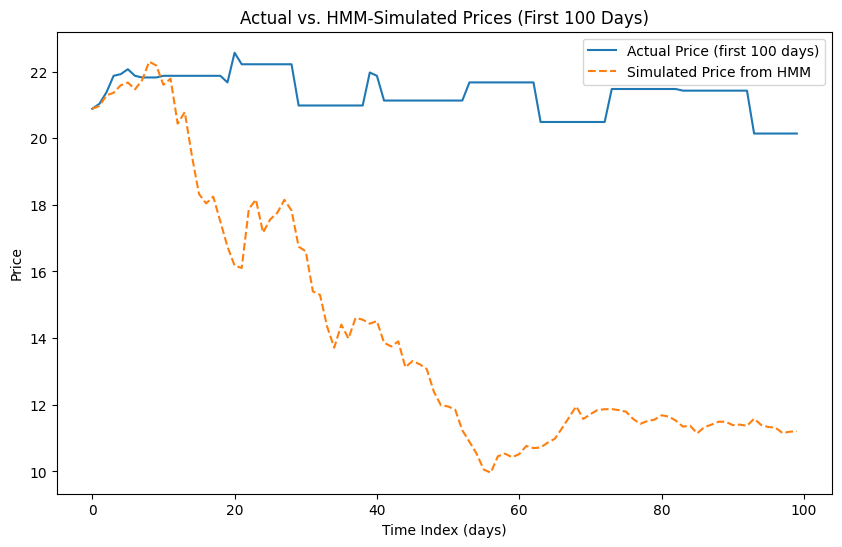

In [17]:
import matplotlib.pyplot as plt
import math

def simulate_hmm(model, n=100):
    """
    Generates a synthetic sequence of hidden states and observations (log returns)
    from a trained HMM.

    Returns:
        sim_states: array of length n with sampled hidden states
        sim_obs:    array of length n with sampled log returns
    """
    start_probs = model.startprob_
    trans_probs = model.transmat_
    means = model.means_
    covars = model.covars_
    n_states = model.n_components

    # 1) Sample initial hidden state
    state = np.random.choice(range(n_states), p=start_probs)
    sim_states = [state]
    sim_obs = []

    # 2) Draw the first observation from the state's Gaussian
    if model.covariance_type == 'full':
        std_dev = math.sqrt(covars[state, 0, 0])
    else:
        std_dev = math.sqrt(covars[state, 0])

    obs = np.random.normal(loc=means[state, 0], scale=std_dev)
    sim_obs.append(obs)

    # 3) Iteratively sample next states and observations
    for _ in range(n - 1):
        state = np.random.choice(range(n_states), p=trans_probs[state])
        sim_states.append(state)

        if model.covariance_type == 'full':
            std_dev = math.sqrt(covars[state, 0, 0])
        else:
            std_dev = math.sqrt(covars[state, 0])

        obs = np.random.normal(loc=means[state, 0], scale=std_dev)
        sim_obs.append(obs)

    return np.array(sim_states), np.array(sim_obs)

# Simulate 100 steps
sim_length = 100
sim_states, sim_obs = simulate_hmm(model, n=sim_length)

# Convert simulated log returns to prices, starting from the actual price on the first day
actual_prices_100 = data_bnp['Close'].values[:sim_length]
initial_price = actual_prices_100[0]

simulated_prices = [initial_price]
for i in range(1, sim_length):
    next_price = simulated_prices[-1] * np.exp(sim_obs[i])
    simulated_prices.append(next_price)

# Plot actual vs simulated
plt.figure(figsize=(10, 6))
plt.plot(range(sim_length), actual_prices_100, label='Actual Price (first 100 days)')
plt.plot(range(sim_length), simulated_prices, label='Simulated Price from HMM', linestyle='--')
plt.title("Actual vs. HMM-Simulated Prices (First 100 Days)")
plt.xlabel("Time Index (days)")
plt.ylabel("Price")
plt.legend()
plt.show()

## 8. In-Sample Prediction Approach 
Finally, we demonstrate an in-sample prediction approach for the first 100 days:
1. We decode the hidden states from the *actual* returns.
2. For day *t*, we use the hidden state from day *(t-1)* to retrieve its mean log return.
3. We exponentiate and multiply to get an estimated price for day *t*.

This shows how the HMM might perform if we continuously updated our knowledge of the hidden state using actual data.

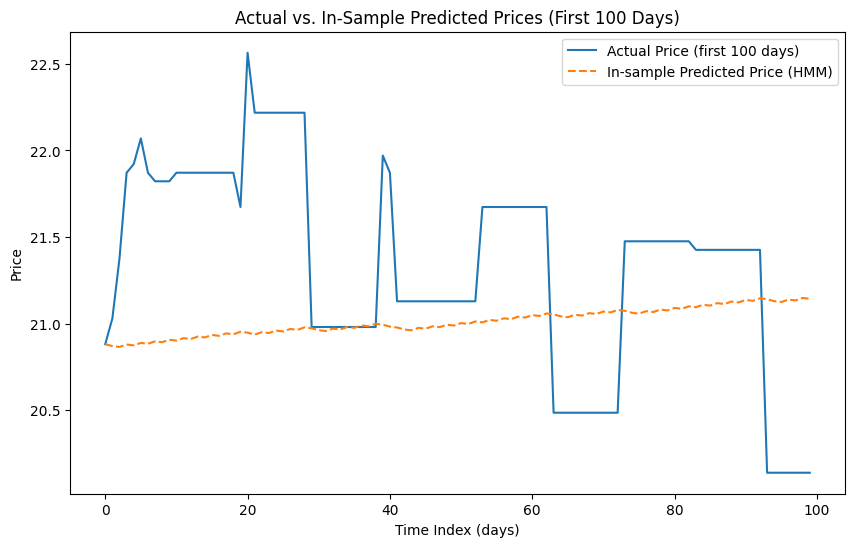

In [18]:
# In-sample prediction
observations_100 = observations[:100]
hidden_states_100 = model.predict(observations_100)
in_sample_prices = np.zeros(100)
actual_prices_100 = data_bnp['Close'].values[:100]

# Use the actual price on day 0 as the starting point
in_sample_prices[0] = actual_prices_100[0]

# For each subsequent day, use the previous day's state to determine the mean return
for t in range(1, 100):
    st = hidden_states_100[t-1]
    mu_t = model.means_[st, 0]
    in_sample_prices[t] = in_sample_prices[t-1] * np.exp(mu_t)

# Plot actual vs in-sample predicted
plt.figure(figsize=(10, 6))
plt.plot(range(100), actual_prices_100, label='Actual Price (first 100 days)')
plt.plot(range(100), in_sample_prices, label='In-sample Predicted Price (HMM)', linestyle='--')
plt.title("Actual vs. In-Sample Predicted Prices (First 100 Days)")
plt.xlabel("Time Index (days)")
plt.ylabel("Price")
plt.legend()
plt.show()